<a href="https://colab.research.google.com/github/mikeusru/scikit-learn-training/blob/main/kaggle_titanic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Titanic Dataset Practice

A well-known dataset used for machine learning practice is a manifest of the passengers on the titanic. Information about the data can be found here:

https://www.kaggle.com/c/titanic

For this lesson, we'll be predicting whether a passenger either survived or died based on the data available.

Need to enable kaggle API (need api token from kaggle.com for this)

https://www.kaggle.com/me/account


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


Now, download the dataset

In [ ]:
!kaggle competitions download -c titanic

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


### Load Data
At this point, we load our data. A lot of people will combine test and train into one dataset here, but i'm going to avoid doing it since we don't want to look at our test dataset until we're ready to make a prediction.

In [ ]:
import pandas as pd
train_df = pd.read_csv('train.csv')
validation_df = pd.read_csv('test.csv')

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
train_df["Cabin"].value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
F2             3
E101           3
              ..
C111           1
D19            1
C49            1
D9             1
A10            1
Name: Cabin, Length: 147, dtype: int64

In [ ]:
train_df["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [ ]:
train_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [ ]:
train_df["SibSp"].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [ ]:
train_df["Parch"].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [ ]:
titanic = train_df.drop(columns=['PassengerId', 'Ticket'])

## Feature Engineering
Cabin has a lot of null values, so we'll make a feature which is just 1 for cabin and 0 for no cabin

In [ ]:
titanic["HasCabin"] = titanic["Cabin"].astype(str) != 'nan'
titanic["HasCabin"] = titanic["HasCabin"].astype(int)
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,HasCabin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,0


## Which features matter?
We can look at histograms of feature distributions, and correlations of features to the survival rate of passengers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa56f5739e8>,
      dtype=object)

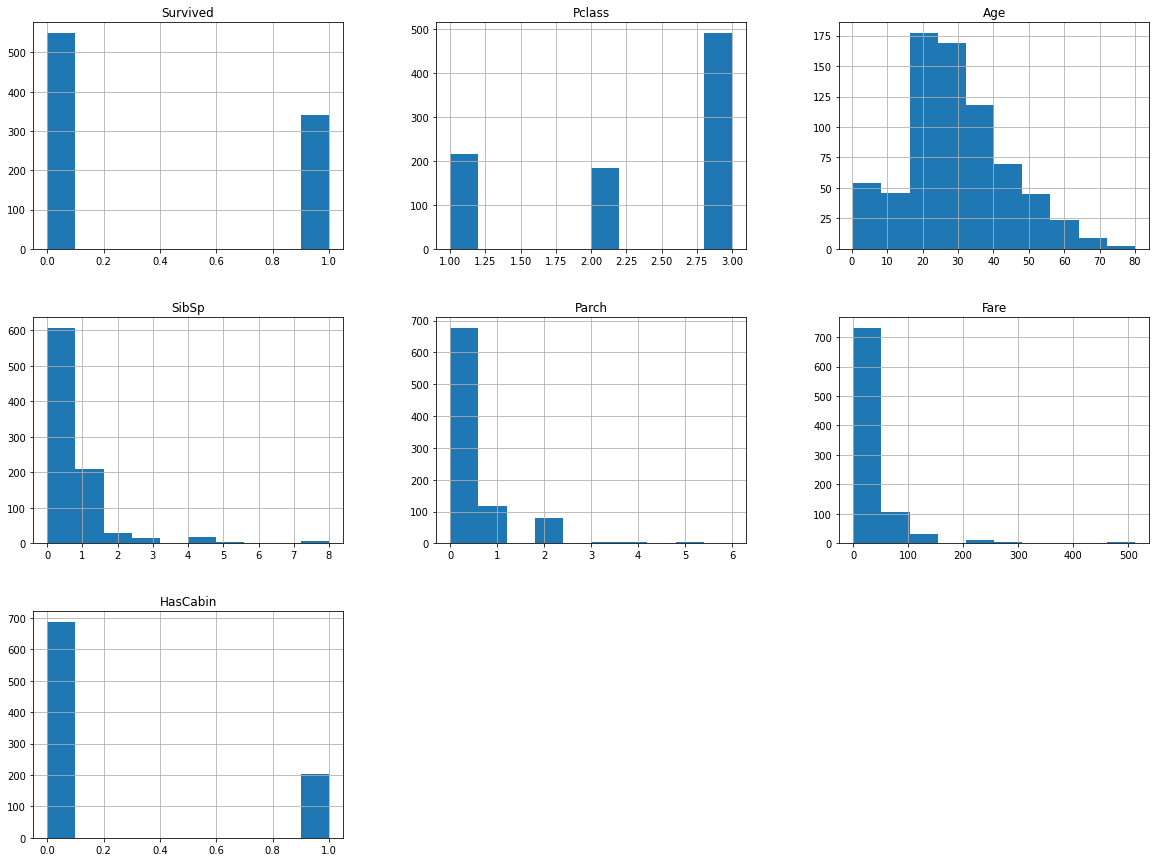

In [ ]:
titanic.hist(bins=10, figsize=(20,15))

In [ ]:
corr_matrix = titanic.corr()

In [ ]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
HasCabin    0.316912
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

## Fill in missing features

We have a number of empty (null) values, as we saw by running the .info() method. We can fill them in with various predictive methods, like the median or mode of each column.

In [ ]:
median_age = titanic['Age'].median()
median_age

28.0

In [ ]:
titanic['Age'].fillna(median_age, inplace=True)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
 10  HasCabin  891 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [ ]:
embarked_mode = titanic['Embarked'].mode()
embarked_mode

0    S
dtype: object

In [ ]:
titanic['Embarked'].fillna(embarked_mode.values[0], inplace=True)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  891 non-null    object 
 10  HasCabin  891 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


## Filling in values with SimpleImputer

We can also use Scikit-Learn's SimpleImputer class to fill in missing values

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

The SimpleImputer will compute all empty numerical values, but we need to separate the numerical from the text values first.

In [ ]:
titanic_num = train_df[['Age', 'SibSp', 'Parch', 'Fare']]
titanic_num.head()

,Age,SibSp,Parch,Fare
0,22.0,1,0,7.2500
1,38.0,1,0,71.2833
2,26.0,0,0,7.9250
3,35.0,1,0,53.1000
4,35.0,0,0,8.0500


In [ ]:
imputer.fit(titanic_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

Let's take a look at what the imputer calculated for each column

In [ ]:
imputer.statistics_

array([28.    ,  0.    ,  0.    , 14.4542])

In [ ]:
X = imputer.transform(titanic_num)
titanic_tr = pd.DataFrame(X, columns=titanic_num.columns, index=titanic_num.index)
titanic_tr.head()

,Age,SibSp,Parch,Fare
0,22.0,1.0,0.0,7.2500
1,38.0,1.0,0.0,71.2833
2,26.0,0.0,0.0,7.9250
3,35.0,1.0,0.0,53.1000
4,35.0,0.0,0.0,8.0500


In [ ]:
titanic_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     891 non-null    float64
 1   SibSp   891 non-null    float64
 2   Parch   891 non-null    float64
 3   Fare    891 non-null    float64
dtypes: float64(4)
memory usage: 28.0 KB


## Filling in categorical data
We can also fill in missing categorical values. Naturally using the median doesn't make sense, but we can use the most commonly occurring values

In [ ]:
cat_imputer = SimpleImputer(strategy="most_frequent")
titanic_cat = train_df[["Embarked", "Sex", "Pclass"]]

cat_imputer.fit(titanic_cat)


SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='most_frequent', verbose=0)

In [ ]:
cat_imputer.statistics_

array(['S', 'male', 3], dtype=object)

In [ ]:
X = cat_imputer.transform(titanic_cat)
titanic_cat_tr = pd.DataFrame(X, columns=titanic_cat.columns, index=titanic_cat.index)
titanic_cat_tr.head()

,Embarked,Sex,Pclass
0,S,male,3
1,C,female,1
2,S,female,3
3,S,female,1
4,S,male,3


## Ordinal Classes
Our data is so clean looking now! Now, we need to change the values of our ordinal classes to make sure they can be represented in a straightforward, numerical manner

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

titanic_cat_encoded = ordinal_encoder.fit_transform(titanic_cat_tr)


In [ ]:
titanic_cat_encoded[:10]

array([[2., 1., 2.],
       [0., 0., 0.],
       [2., 0., 2.],
       [2., 0., 0.],
       [2., 1., 2.],
       [1., 1., 2.],
       [2., 1., 0.],
       [2., 1., 2.],
       [2., 0., 2.],
       [0., 0., 1.]])

In [ ]:
ordinal_encoder.categories_

[array(['C', 'Q', 'S'], dtype=object),
 array(['female', 'male'], dtype=object),
 array([1, 2, 3], dtype=object)]

## One-Hot Encoding
To avoid the algorithm thinking that C is closer to Q than to S because 0 is closer to 1 than to 2, we change numbers to one-hot encoding, where each number is changed to an array of zeros and ones. 0 becomes [1 0 0], 1 becomes [0 1 0], and 2 becomes [0 0 1] 


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
embarked_encoder = OneHotEncoder()
# titanic_embarked_cat_encoded = np.expand_dims(titanic_cat_encoded[:,0], axis=1)
embarked_cat_1hot = embarked_encoder.fit_transform(titanic_cat_tr[['Embarked','Pclass']])
embarked_cat_1hot

<891x6 sparse matrix of type '<class 'numpy.float64'>'
	with 1782 stored elements in Compressed Sparse Row format>

In [ ]:
embarked_cat_1hot.toarray()

array([[0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1.]])

In [ ]:
embarked_encoder.categories_

[array(['C', 'Q', 'S'], dtype=object), array([1, 2, 3], dtype=object)]

## Custom Transformers

To recreate our steps from before and put them in a pipeline, we're going to make a custom transformer which will extract the appropriate cabin values and simply replace them with the ones already there

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CabinTransformer(BaseEstimator, TransformerMixin):
  
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X = (X.astype(str) != 'nan').astype(float)
    return X

## Transformation Pipelines

We're going to make a nice, clean pipeline now where all of our transformations are clearly identifiable. Also, we're going to add a scaler to standardize our numerical values.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy="median")),
                         ('std_scaler', StandardScaler()),
])

cabin_pipeline = Pipeline([
                           ('has_cabin', CabinTransformer()),
])

embarked_pipeline = Pipeline([
                              ('imputer', SimpleImputer(strategy="most_frequent")),
                              ('cat', OneHotEncoder()),
])


In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cabin_attribs = ['Cabin']
ordinal_attribs = ['Sex']
cat_attribs = ['Embarked', 'Pclass']

full_pipeline = ColumnTransformer([
                                   ("num", num_pipeline, num_attribs),
                                   ("has_cabin", cabin_pipeline, cabin_attribs),
                                   ("ord", OrdinalEncoder(), ordinal_attribs),
                                   ("cat", embarked_pipeline, cat_attribs),
])

titanic_prepared = full_pipeline.fit_transform(train_df)

Just to take another look at what our data's turned into, we can load it into a dataframe again, but i wouldn't recommend doing this normally. At this point, we should know what our stuff looks like without needing to write labels like this.

In [ ]:
new_cols = ['Age','SibSp','Parch','Fare','Cabin','Sex','Embarked1','Embarked2','Embarked3','Pclass1','Pclass2','Pclass3']
train_df_tr = pd.DataFrame(titanic_prepared, columns=new_cols, index=train_df.index)
train_df_tr.head()


,Age,SibSp,Parch,Fare,Cabin,Sex,Embarked1,Embarked2,Embarked3,Pclass1,Pclass2,Pclass3
0,-0.565736,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.663861,0.432793,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.258337,-0.474545,-0.473674,-0.488854,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.433312,0.432793,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.433312,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


# Training
Awesome, our data is clean, numerical, and ready for training. We'll now pick a model and prepare our training/test sets.

Although the titanic train/test sets are divided up for us, the test set is unlabeled, and will therefore serve as our validation set (after we're done tuning model parameters etc, we submit to kaggle to get our answer). We'll actually split the train_df into train_df and test_df

In [ ]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(titanic_prepared, train_df['Survived'], test_size=0.33, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((596, 12), (295, 12), (596,), (295,))

## Testing a model
Our data is clean and ready to go! We'll try the Stochastic Gradiant Descent classifier first. Just a normal classifier people try, nothing special. It'll work on our binary classification problem.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=RANDOM_SEED)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

As you see from the output, the classifier trained with a whole bunch of hyperparameters, but we didn't need to set them yet, just working with the defaults. It's easier to start like this - once we pick a model that works well, we can start playing w/ hyperparameters and such. We can now use our model to predict whether someone died - let's pick a person from the test set!

In [ ]:
f'Prediction: {sgd_clf.predict([X_test[0,:]])[0]}, Actual: {y_test.values[0]}'

'Prediction: 0, Actual: 1'

Whoops, wrong prediction! But one prediction is meaningless.... let's measure the performance of our model on more test data. We can easily get an accuracy score of how the model predicts our test data

In [ ]:
sgd_clf.score(X_test,y_test)


0.752542372881356

There you have it! We have a 75% accuracy. Go, us! Better than 50%! 

## Cross-Validation
We want to get better at evaluating our model though, especially considering the small amount of data available in the titanic dataset. Small datasets mean overfitting, and cross-validation will allow us to reduce the chances of overfitting due to sampling noise. 

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84422111, 0.69849246, 0.7020202 ])

Depending on how we split our train/test data, our scores vary from 84 to 70% accuracy. This is truly horrible! I'd say we need more data, but that would mean i wanted more people to die on the titanic, so let's leave this as a small-data problem forever. We can, however, average our cross-validation scores to test other models, and we can look at other metrics other than accuracy.

Before testing other metrics and models, let's try something simple. What if our model always predicted for passengers to die?

In [ ]:
from sklearn.base import BaseEstimator
class AlwaysDeadClassifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)
    

In [ ]:
everyone_dies = AlwaysDeadClassifier()
cross_val_score(everyone_dies, X_train, y_train, cv=3, scoring='accuracy')

array([0.59798995, 0.65829146, 0.62626263])

Worse than our model, but not by a lot!
## Confusion Matrix

We can better evaluate our model using scores other than just accuracy, which can often be misleading. We can look at what the model got right, as well as what it got wrong. A way of doing this is the Confusion Matrix.

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[286,  88],
       [ 62, 160]])

Each row represents an actual class, while each column represents a predicted class. 160 survivors correctly predicted, 286 deadites predicted correctly as well. But there were a bunch of wrong choices. We can get into accuracy, precision, and f1 score here, but it's not as meaningful for this task. What I really want is a simple metric to compare models. Let's just get better results!

## Decision Trees, Random Forests

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=RANDOM_SEED)
cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="accuracy")


array([0.77889447, 0.69346734, 0.77777778])

A decision tree looks more promising. And you know what? We can visualize the steps it's taking! There's a software package called graphviz which allows us to make graphs. This step is definitely unnecessary but I think it's a good thing to know in general.

In [ ]:
from sklearn.tree import export_graphviz

tree_clf.fit(X_train, y_train)

export_graphviz(
    tree_clf, 
    out_file='titanic_tree.dot',
    feature_names= ['Age','SibSp','Parch','Fare','Cabin','Sex','Embarked1','Embarked2','Embarked3','Pclass1','Pclass2','Pclass3'],
    class_names=["Survived","Died"],
    rounded=True,
    filled=True,
)

You need to export the graphviz .dot file to a .png through the command line

In [ ]:
!dot -Tpng titanic_tree.dot -o titanic_tree.png

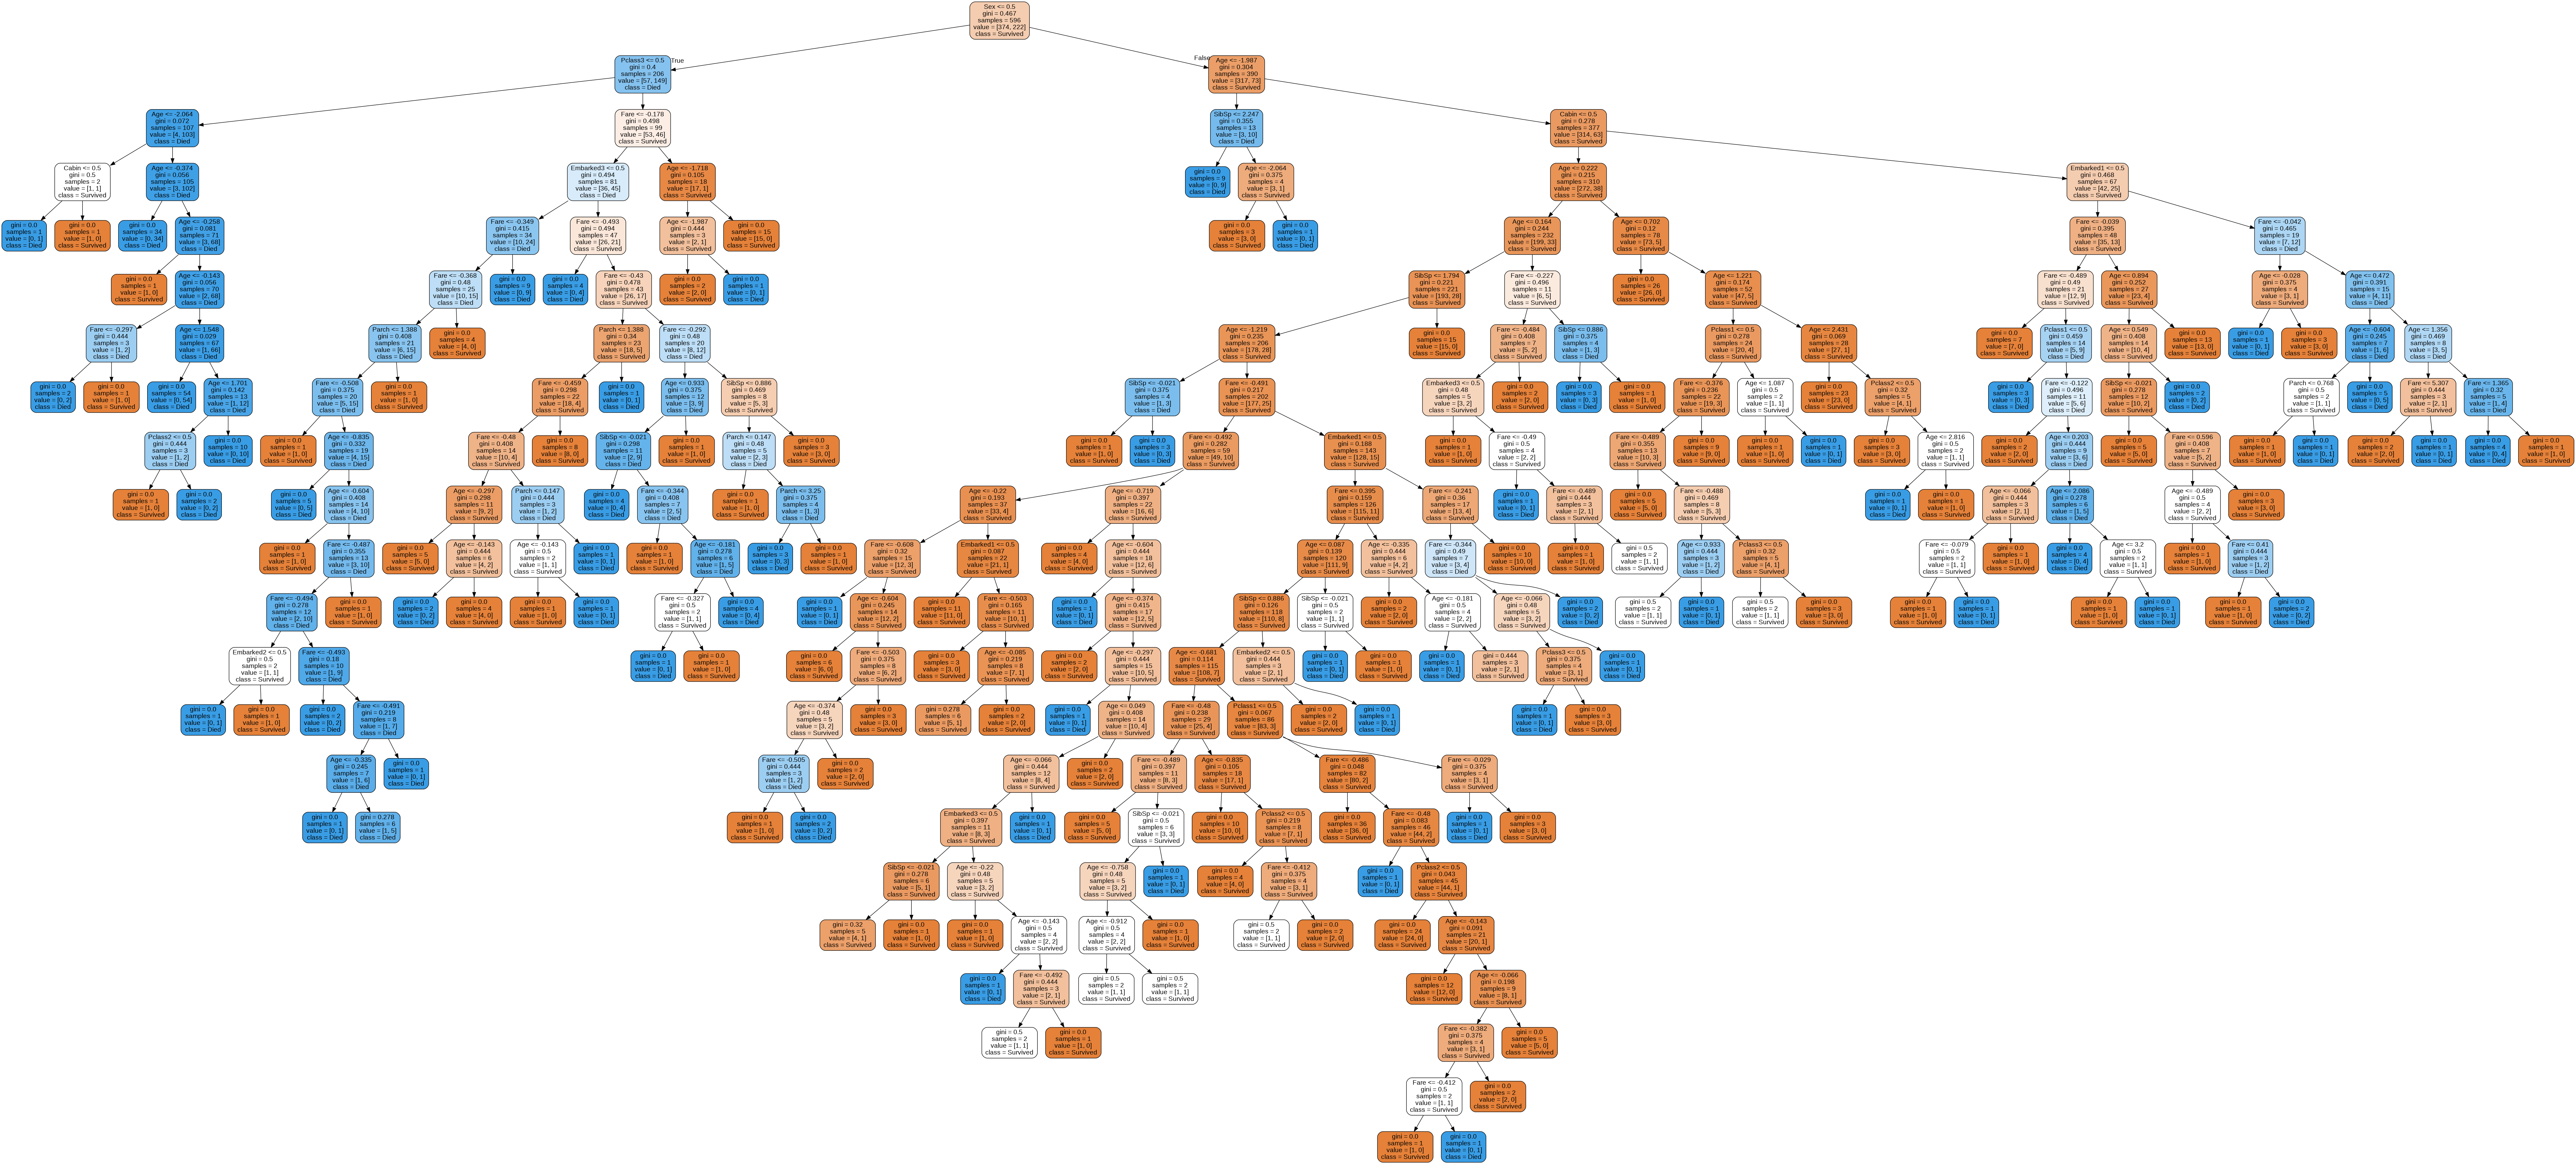

That is a spectacularly terribly overfit decision tree. If you look closely, plenty of decision points have groups of 2 or 3 passengers, which is just trash. We can change this!


In [ ]:
tree_clf = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=5, min_samples_split=20)
tree_clf.fit(X_train, y_train)

export_graphviz(
    tree_clf, 
    out_file='titanic_tree_small.dot',
    feature_names= ['Age','SibSp','Parch','Fare','Cabin','Sex','Embarked1','Embarked2','Embarked3','Pclass1','Pclass2','Pclass3'],
    class_names=["Survived","Died"],
    rounded=True,
    filled=True,
)

In [ ]:
!dot -Tpng titanic_tree_small.dot -o titanic_tree_small.png

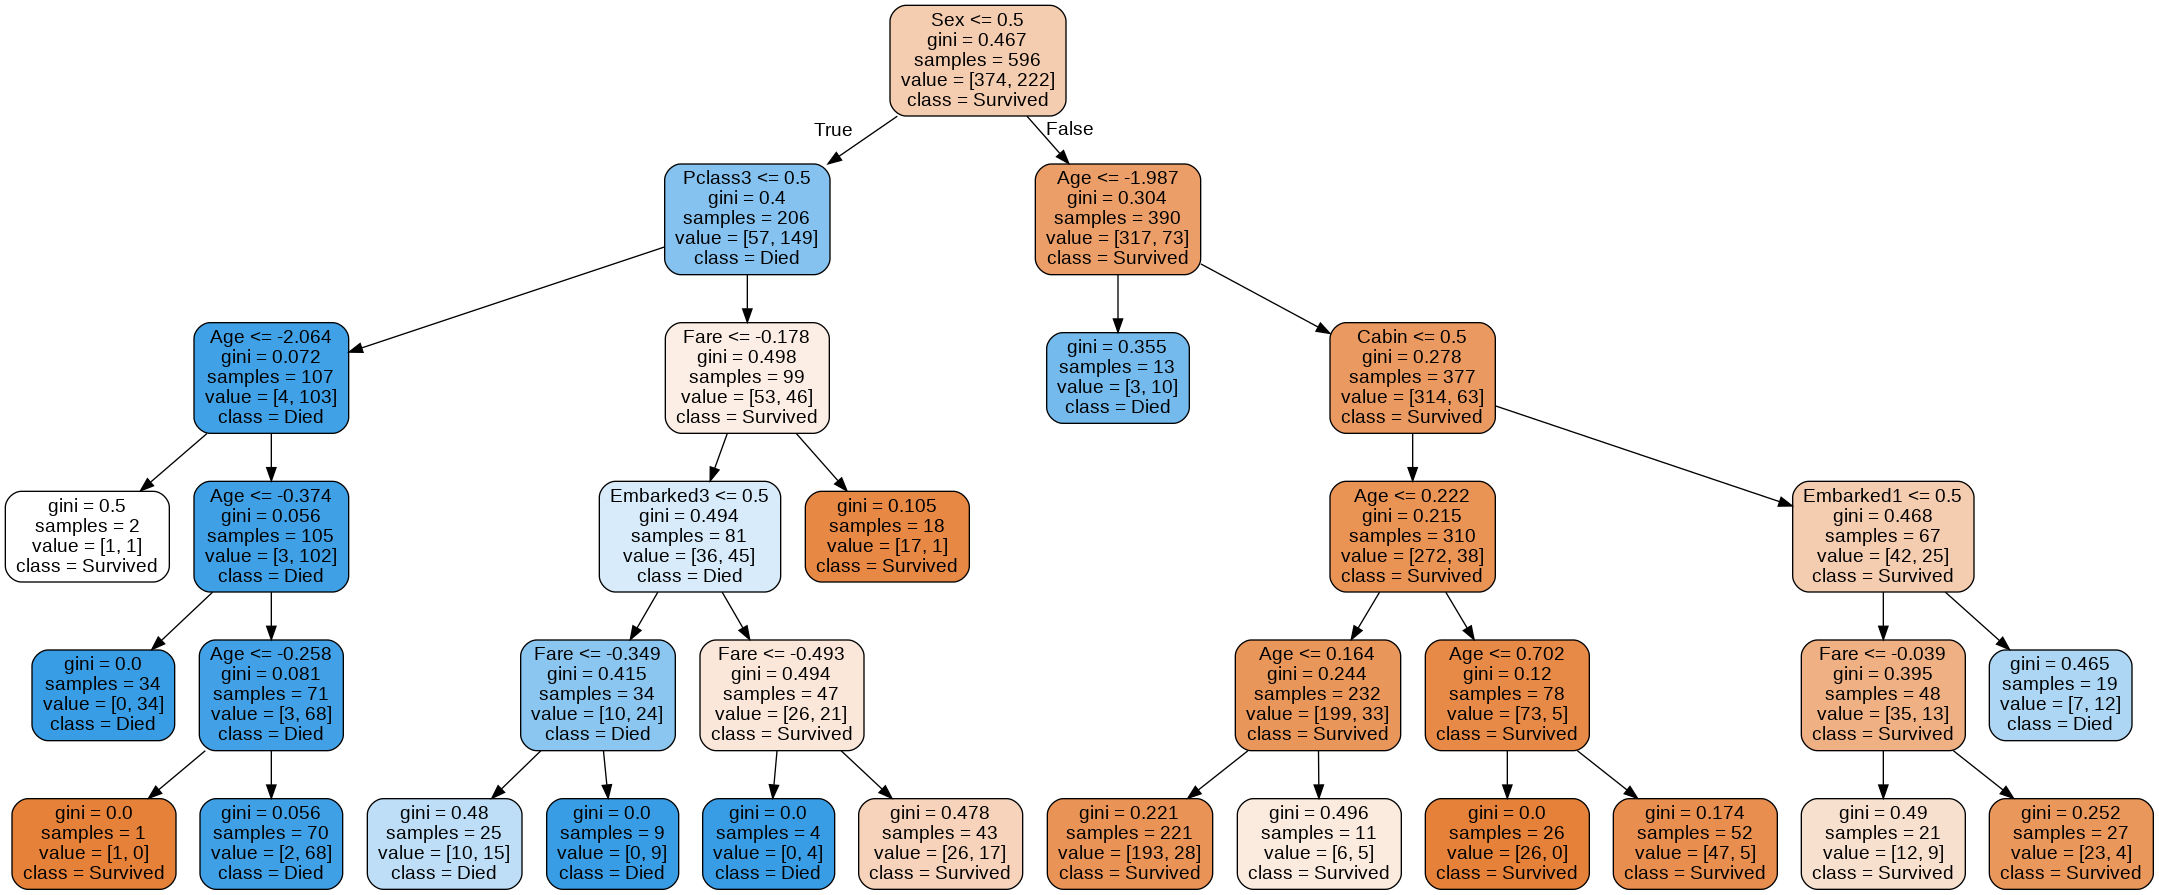

That's a bit more manageable. In fact, decision trees are referred to as *white box* models, meaning they're easy to interpret. However, it actually turns out that using a bunch of small, underfit trees tends to be better than just one big one - this is referred to as a Random Forest. Random forests, like neural networks, are referred to as *black box* models - they are difficult to interpret.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=RANDOM_SEED)
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8040201 , 0.78894472, 0.82323232])

Heyy! That looks even better. I guess ... something... forest for the trees...? nope I lost it. Moving on!
## Predicting the full test set
We have chosen our model for now, and it's the Random Forest Classifier. We're going to train it on our FULL training set, make the predictions on our validation set, and upload those to kaggle.

Once again, we need to run our data through the preprocessing pipeline. It's important that we fit the pipeline on our training data, and **avoid refitting on the test set**. Note that we do fit_transform (a combo of fit and transform), and then just transform.

Since the train and test set have to be the same size for the pipeline, we remove the target values from the train set prior to this preprocessing step

In [ ]:
y_train = train_df['Survived'].values
train_df.drop(columns=['Survived'], inplace=True)

titanic_prepared_train = full_pipeline.fit_transform(train_df)
titanic_prepared_test = full_pipeline.transform(validation_df)

In [ ]:
titanic_prepared_train.shape, titanic_prepared_test.shape

In [ ]:
forest_clf.fit(titanic_prepared_train, y_train)

In [ ]:
y_pred = forest_clf.predict(titanic_prepared_test)
y_pred

## Save Results
And there's our prediction :D
Now we can export these results as a csv file (and even upload them to kaggle directly?!?) 

In [ ]:
results_df = pd.DataFrame(validation_df['PassengerId'])
results_df['Survived'] = y_pred

In [ ]:
results_df.head()

In [ ]:
results_df.to_csv('titanic_prediction.csv', index=False)

In [ ]:
!kaggle competitions submit -c titanic -f titanic_prediction.csv -m "Random Forest - https://github.com/mikeusru/scikit-learn-training"